In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

$$
\frac{\partial^2 T(x,y,t)}{\partial x^2} + \frac{\partial^2 T(x,y,t)}{\partial y^2} -\frac{1}{\alpha}\frac{\partial T(x,y,t)}{\partial t} = 0
$$

$T(x,y,z)$ is neural network.

In [34]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(3, 16) # x, y, t
        self.fc2 = torch.nn.Linear(16, 16)
        self.fc3 = torch.nn.Linear(16, 16)
        self.fc4 = torch.nn.Linear(16, 16)
        self.fc5 = torch.nn.Linear(16, 16)
        self.fc6 = torch.nn.Linear(16, 1) # T
        self.act = torch.nn.SiLU() # for continuity
    
    def forward(self, x:torch.Tensor, y:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        x = torch.cat((x, y, t), dim=1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        x = self.act(self.fc5(x))
        x = self.fc6(x)
        return x
    
def func(net:torch.nn.Module, x:torch.Tensor, y:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
    T = net(x, y, t)
    T_x = torch.autograd.grad(T, x, torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x, torch.ones_like(T_x), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, torch.ones_like(T), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, torch.ones_like(T_y), create_graph=True)[0]
    T_t = torch.autograd.grad(T, t, torch.ones_like(T), create_graph=True)[0]
    return T_t - T_xx - T_yy

In [35]:
net = Net().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

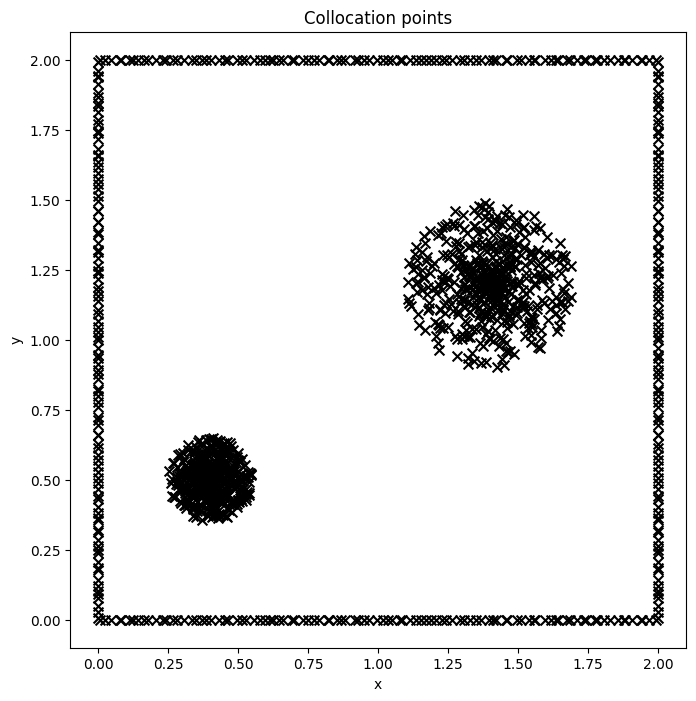

In [31]:
# init condition

# boundary box
init_cond_coord_0 = sp.stats.qmc.LatinHypercube(d=2).random(n=100)
init_cond_coord_0 = sp.stats.qmc.scale(init_cond_coord_0, [0, 0], [2, 2])
init_cond_x_0, init_cond_y_0 = init_cond_coord_0[:, 0], init_cond_coord_0[:, 1]
init_cond_i_0 = np.zeros_like(init_cond_x_0)
init_cond_o_0 = np.full_like(init_cond_x_0, 2)
init_cond_t_0 = np.full_like(init_cond_x_0, 0)
init_cond_u_0 = np.full_like(init_cond_x_0, 1)

# circle 0
radius_0 = 0.15
center_0 = np.array([0.4, 0.5])
init_cond_coord_1 = sp.stats.qmc.LatinHypercube(d=2).random(n=500)
init_cond_coord_1 = sp.stats.qmc.scale(init_cond_coord_1, [0, 0], [2 * np.pi, radius_0])
init_cond_theta_1, init_cond_r_1 = init_cond_coord_1[:, 0], init_cond_coord_1[:, 1]
init_cond_x_1 = center_0[0] + init_cond_r_1 * np.cos(init_cond_theta_1)
init_cond_y_1 = center_0[1] + init_cond_r_1 * np.sin(init_cond_theta_1)
init_cond_t_1 = np.full_like(init_cond_x_1, 0)
init_cond_u_1 = np.full_like(init_cond_x_1, 0)

# circle 1
radius_1 = 0.3
center_1 = np.array([1.4, 1.2])
init_cond_coord_2 = sp.stats.qmc.LatinHypercube(d=2).random(n=500)
init_cond_coord_2 = sp.stats.qmc.scale(init_cond_coord_2, [0, 0], [2 * np.pi, radius_1])
init_cond_theta_2, init_cond_r_2 = init_cond_coord_2[:, 0], init_cond_coord_2[:, 1]
init_cond_x_2 = center_1[0] + init_cond_r_2 * np.cos(init_cond_theta_2)
init_cond_y_2 = center_1[1] + init_cond_r_2 * np.sin(init_cond_theta_2)
init_cond_t_2 = np.full_like(init_cond_x_2, 0)
init_cond_u_2 = np.full_like(init_cond_x_2, 0)

plt.figure(figsize=(8, 8))
plt.scatter(init_cond_x_0, init_cond_i_0, s=50, marker='x', c='k')
plt.scatter(init_cond_x_0, init_cond_o_0, s=50, marker='x', c='k')
plt.scatter(init_cond_i_0, init_cond_y_0, s=50, marker='x', c='k')
plt.scatter(init_cond_o_0, init_cond_y_0, s=50, marker='x', c='k')

plt.scatter(init_cond_x_1, init_cond_y_1, s=50, marker='x', c='k')
plt.scatter(init_cond_x_2, init_cond_y_2, s=50, marker='x', c='k')

plt.title('Collocation points')
plt.xlim([-0.1, 2.1])
plt.ylim([-0.1, 2.1])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [33]:
# boundary condition

# boundary box u=0 at t>0
bnd_cond_coord_0 = sp.stats.qmc.LatinHypercube(d=3).random(n=100)
bnd_cond_coord_0 = sp.stats.qmc.scale(bnd_cond_coord_0, [0, 0, 0], [2, 2, 1])
bnd_cond_x_0, bnd_cond_y_0, bnd_cond_t_0 = \
    bnd_cond_coord_0[:, 0], bnd_cond_coord_0[:, 1], bnd_cond_coord_0[:, 2]
bnd_cond_i_0 = np.zeros_like(bnd_cond_x_0)
bnd_cond_o_0 = np.full_like(bnd_cond_x_0, 2)
bnd_cond_u_0 = np.full_like(bnd_cond_x_0, 0)

radius_0 = 0.15
center_0 = np.array([0.4, 0.5])
bnd_cond_coord_1 = sp.stats.qmc.LatinHypercube(d=3).random(n=500)
bnd_cond_coord_1 = sp.stats.qmc.scale(bnd_cond_coord_1, [0, 0, 0], [2 * np.pi, radius_0, 1])
bnd_cond_theta_1, bnd_cond_r_1, bnd_cond_t_1 = \
    bnd_cond_coord_1[:, 0], bnd_cond_coord_1[:, 1], bnd_cond_coord_1[:, 2]
bnd_cond_x_1 = center_0[0] + bnd_cond_r_1 * np.cos(bnd_cond_theta_1)
bnd_cond_y_1 = center_0[1] + bnd_cond_r_1 * np.sin(bnd_cond_theta_1)
bnd_cond_u_1 = np.full_like(bnd_cond_x_1, 1)

radius_1 = 0.3
center_1 = np.array([1.4, 1.2])
bnd_cond_coord_2 = sp.stats.qmc.LatinHypercube(d=3).random(n=500)
bnd_cond_coord_2 = sp.stats.qmc.scale(bnd_cond_coord_2, [0, 0, 0], [2 * np.pi, radius_1, 1])
bnd_cond_theta_2, bnd_cond_r_2, bnd_cond_t_2 = \
    bnd_cond_coord_2[:, 0], bnd_cond_coord_2[:, 1], bnd_cond_coord_2[:, 2]
bnd_cond_x_2 = center_1[0] + bnd_cond_r_2 * np.cos(bnd_cond_theta_2)
bnd_cond_y_2 = center_1[1] + bnd_cond_r_2 * np.sin(bnd_cond_theta_2)
bnd_cond_u_2 = np.full_like(bnd_cond_x_2, 1)

In [45]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.init_x, self.init_y, self.init_t, self.init_u = self.get_init_cond()
        self.bnd_x, self.bnd_y, self.bnd_t, self.bnd_u = self.get_bnd_cond()
        self.colloc_x, self.colloc_y, self.colloc_t, self.colloc_u = self.get_colloc_cond()

    def get_bnd_cond(self):
        bnd_cond_coord_0 = sp.stats.qmc.LatinHypercube(d=3).random(n=200)
        bnd_cond_coord_0 = sp.stats.qmc.scale(bnd_cond_coord_0, [0, 0, 0], [2, 2, 1])
        bnd_cond_x_0, bnd_cond_y_0, bnd_cond_t_0 = \
            bnd_cond_coord_0[:, 0], bnd_cond_coord_0[:, 1], bnd_cond_coord_0[:, 2]
        bnd_cond_i_0 = np.zeros_like(bnd_cond_x_0)
        bnd_cond_o_0 = np.full_like(bnd_cond_x_0, 2)
        bnd_cond_u_0 = np.full_like(bnd_cond_x_0, 0)

        radius_0 = 0.15
        center_0 = np.array([0.4, 0.5])
        bnd_cond_coord_1 = sp.stats.qmc.LatinHypercube(d=3).random(n=400)
        bnd_cond_coord_1 = sp.stats.qmc.scale(bnd_cond_coord_1, [0, 0, 0], [2 * np.pi, radius_0, 1])
        bnd_cond_theta_1, bnd_cond_r_1, bnd_cond_t_1 = \
            bnd_cond_coord_1[:, 0], bnd_cond_coord_1[:, 1], bnd_cond_coord_1[:, 2]
        bnd_cond_x_1 = center_0[0] + bnd_cond_r_1 * np.cos(bnd_cond_theta_1)
        bnd_cond_y_1 = center_0[1] + bnd_cond_r_1 * np.sin(bnd_cond_theta_1)
        bnd_cond_u_1 = np.full_like(bnd_cond_x_1, 1)

        radius_1 = 0.3
        center_1 = np.array([1.4, 1.2])
        bnd_cond_coord_2 = sp.stats.qmc.LatinHypercube(d=3).random(n=400)
        bnd_cond_coord_2 = sp.stats.qmc.scale(bnd_cond_coord_2, [0, 0, 0], [2 * np.pi, radius_1, 1])
        bnd_cond_theta_2, bnd_cond_r_2, bnd_cond_t_2 = \
            bnd_cond_coord_2[:, 0], bnd_cond_coord_2[:, 1], bnd_cond_coord_2[:, 2]
        bnd_cond_x_2 = center_1[0] + bnd_cond_r_2 * np.cos(bnd_cond_theta_2)
        bnd_cond_y_2 = center_1[1] + bnd_cond_r_2 * np.sin(bnd_cond_theta_2)
        bnd_cond_u_2 = np.full_like(bnd_cond_x_2, 1)

        bnd_cond_x = np.concatenate([
            bnd_cond_x_0, bnd_cond_x_0, bnd_cond_i_0, bnd_cond_o_0,
            bnd_cond_x_1, bnd_cond_x_2], axis=0)
        bnd_cond_y = np.concatenate([
            bnd_cond_i_0, bnd_cond_o_0, bnd_cond_y_0, bnd_cond_y_0,
            bnd_cond_y_1, bnd_cond_y_2], axis=0)
        bnd_cond_t = np.concatenate([
            bnd_cond_t_0, bnd_cond_t_0, bnd_cond_t_0, bnd_cond_t_0,
            bnd_cond_t_1, bnd_cond_t_2], axis=0)
        bnd_cond_u = np.concatenate([
            bnd_cond_u_0, bnd_cond_u_0, bnd_cond_u_0, bnd_cond_u_0,
            bnd_cond_u_1, bnd_cond_u_2], axis=0)

        bnd_cond_x = torch.from_numpy(bnd_cond_x[:, None]).float()
        bnd_cond_x = torch.autograd.Variable(bnd_cond_x, requires_grad=False)
        bnd_cond_y = torch.from_numpy(bnd_cond_y[:, None]).float()
        bnd_cond_y = torch.autograd.Variable(bnd_cond_y, requires_grad=False)
        bnd_cond_t = torch.from_numpy(bnd_cond_t[:, None]).float()
        bnd_cond_t = torch.autograd.Variable(bnd_cond_t, requires_grad=False)
        bnd_cond_u = torch.from_numpy(bnd_cond_u[:, None]).float()
        bnd_cond_u = torch.autograd.Variable(bnd_cond_u, requires_grad=False)
        return bnd_cond_x, bnd_cond_y, bnd_cond_t, bnd_cond_u

    def get_init_cond(self):
        init_cond_sample_0 = sp.stats.qmc.LatinHypercube(d=2).random(n=200)
        init_cond_sample_0 = sp.stats.qmc.scale(init_cond_sample_0, [0, 0], [2, 2])
        init_cond_x_0, init_cond_y_0 = init_cond_sample_0[:, 0], init_cond_sample_0[:, 1]
        init_cond_i_0 = np.zeros_like(init_cond_x_0)
        init_cond_o_0 = np.full_like(init_cond_x_0, 2)
        init_cond_t_0 = np.full_like(init_cond_x_0, 0)
        init_cond_u_0 = np.full_like(init_cond_x_0, 1)

        radius_0 = 0.15
        center_0 = np.array([0.4, 0.5])
        init_cond_sample_1 = sp.stats.qmc.LatinHypercube(d=2).random(n=400)
        init_cond_sample_1 = sp.stats.qmc.scale(init_cond_sample_1, [0, 0], [2 * np.pi, radius_0])
        init_cond_theta_1, init_cond_r_1 = init_cond_sample_1[:, 0], init_cond_sample_1[:, 1]
        init_cond_x_1 = center_0[0] + init_cond_r_1 * np.cos(init_cond_theta_1)
        init_cond_y_1 = center_0[1] + init_cond_r_1 * np.sin(init_cond_theta_1)
        init_cond_t_1 = np.full_like(init_cond_x_1, 0)
        init_cond_u_1 = np.full_like(init_cond_x_1, 0)

        radius_1 = 0.3
        center_1 = np.array([1.4, 1.2])
        init_cond_sample_2 = sp.stats.qmc.LatinHypercube(d=2).random(n=400)
        init_cond_sample_2 = sp.stats.qmc.scale(init_cond_sample_2, [0, 0], [2 * np.pi, radius_1])
        init_cond_theta_2, init_cond_r_2 = init_cond_sample_2[:, 0], init_cond_sample_2[:, 1]
        init_cond_x_2 = center_1[0] + init_cond_r_2 * np.cos(init_cond_theta_2)
        init_cond_y_2 = center_1[1] + init_cond_r_2 * np.sin(init_cond_theta_2)
        init_cond_t_2 = np.full_like(init_cond_x_2, 0)
        init_cond_u_2 = np.full_like(init_cond_x_2, 0)

        init_cond_x = np.concatenate([
            init_cond_x_0, init_cond_x_0, init_cond_i_0, init_cond_o_0,
            init_cond_x_1, init_cond_x_2], axis=0)
        init_cond_y = np.concatenate([
            init_cond_i_0, init_cond_o_0, init_cond_y_0, init_cond_y_0,
            init_cond_y_1, init_cond_y_2], axis=0)
        init_cond_t = np.concatenate([
            init_cond_t_0, init_cond_t_0, init_cond_t_0, init_cond_t_0,
            init_cond_t_1, init_cond_t_2], axis=0)
        init_cond_u = np.concatenate([
            init_cond_u_0, init_cond_u_0, init_cond_u_0, init_cond_u_0,
            init_cond_u_1, init_cond_u_2], axis=0)
    
        init_cond_x = torch.from_numpy(init_cond_x[:, None]).float()
        init_cond_x = torch.autograd.Variable(init_cond_x, requires_grad=False)
        init_cond_y = torch.from_numpy(init_cond_y[:, None]).float()
        init_cond_y = torch.autograd.Variable(init_cond_y, requires_grad=False)
        init_cond_t = torch.from_numpy(init_cond_t[:, None]).float()
        init_cond_t = torch.autograd.Variable(init_cond_t, requires_grad=False)
        init_cond_u = torch.from_numpy(init_cond_u[:, None]).float()
        init_cond_u = torch.autograd.Variable(init_cond_u, requires_grad=False)
        return init_cond_x, init_cond_y, init_cond_t, init_cond_u
    
    def get_colloc_cond(self):
        colloc_coord = sp.stats.qmc.LatinHypercube(d=3).random(n=1000)
        colloc_coord = sp.stats.qmc.scale(colloc_coord, [0, 0, 0], [2, 2, 1])
        colloc_x, colloc_y, colloc_t = colloc_coord[:, 0], colloc_coord[:, 1], colloc_coord[:, 2]
        colloc_u = np.zeros_like(colloc_x)

        colloc_x = torch.from_numpy(colloc_x[:, None]).float()
        colloc_x = torch.autograd.Variable(colloc_x, requires_grad=True)
        colloc_y = torch.from_numpy(colloc_y[:, None]).float()
        colloc_y = torch.autograd.Variable(colloc_y, requires_grad=True)
        colloc_t = torch.from_numpy(colloc_t[:, None]).float()
        colloc_t = torch.autograd.Variable(colloc_t, requires_grad=True)
        colloc_u = torch.from_numpy(colloc_u[:, None]).float()
        colloc_u = torch.autograd.Variable(colloc_u, requires_grad=False)
        return colloc_x, colloc_y, colloc_t, colloc_u

    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        return dict(
            init=(self.init_x[idx], self.init_y[idx], self.init_t[idx], self.init_u[idx]),
            bnd=(self.bnd_x[idx], self.bnd_y[idx], self.bnd_t[idx], self.bnd_u[idx]),
            colloc=(self.colloc_x[idx], self.colloc_y[idx], self.colloc_t[idx], self.colloc_u[idx])
        )

train_dataset = TrainDataset()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [46]:
EPOCHS = 20000
history = []

for epoch in range(EPOCHS):
    loss_tmp = []
    for i, batch in enumerate(train_loader):
        init_x, init_y, init_t, init_u = batch['init']
        bnd_x, bnd_y, bnd_t, bnd_u = batch['bnd']
        colloc_x, colloc_y, colloc_t, colloc_u = batch['colloc']

        init_x = init_x.to(device)
        init_y = init_y.to(device)
        init_t = init_t.to(device)
        init_u = init_u.to(device)
        bnd_x = bnd_x.to(device)
        bnd_y = bnd_y.to(device)
        bnd_t = bnd_t.to(device)
        bnd_u = bnd_u.to(device)
        colloc_x = colloc_x.to(device)
        colloc_y = colloc_y.to(device)
        colloc_t = colloc_t.to(device)
        colloc_u = colloc_u.to(device)

        optimizer.zero_grad()
        init_pred = net(init_x, init_y, init_t)
        bnd_pred = net(bnd_x, bnd_y, bnd_t)
        colloc_pred = func(net, colloc_x, colloc_y, colloc_t)
        loss = criterion(init_pred, init_u) + criterion(bnd_pred, bnd_u) + criterion(colloc_pred, colloc_u)
        loss.backward()
        loss_tmp.append(loss.item())
        optimizer.step()
    
        print(f'\rEpoch [{epoch+1}/{EPOCHS}], Batch [{i+1}/{len(train_loader)}] Loss: {np.mean(loss_tmp):.5f}', end='')
    print()
    history.append(np.mean(loss_tmp))

Epoch [1/20000], Batch [8/8] Loss: 0.64248
Epoch [2/20000], Batch [8/8] Loss: 0.63871
Epoch [3/20000], Batch [8/8] Loss: 0.63498
Epoch [4/20000], Batch [8/8] Loss: 0.63132
Epoch [5/20000], Batch [8/8] Loss: 0.62770
Epoch [6/20000], Batch [8/8] Loss: 0.62414
Epoch [7/20000], Batch [8/8] Loss: 0.62064
Epoch [8/20000], Batch [8/8] Loss: 0.61718
Epoch [9/20000], Batch [8/8] Loss: 0.61376
Epoch [10/20000], Batch [8/8] Loss: 0.61039
Epoch [11/20000], Batch [8/8] Loss: 0.60707
Epoch [12/20000], Batch [8/8] Loss: 0.60377
Epoch [13/20000], Batch [8/8] Loss: 0.60051
Epoch [14/20000], Batch [8/8] Loss: 0.59729
Epoch [15/20000], Batch [8/8] Loss: 0.59409
Epoch [16/20000], Batch [8/8] Loss: 0.59094
Epoch [17/20000], Batch [8/8] Loss: 0.58781


KeyboardInterrupt: 